In [1]:
import config_readwrite as crw
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pandas as pd

from scipy import stats
from sklearn.preprocessing import StandardScaler
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

# params

In [40]:
#/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/hob/class.all.1task_windows/class.all.1task_windows.model
CL = 'hob'#"hepg2"#"hob"
PREFIX = "class.all" #"class.all.1task_windows"

balanced_window = ".1task_windows"#
if balanced_window is not None:
    DATA_PATH = f"/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/{CL}/{PREFIX+balanced_window}/"
else:
    DATA_PATH =  f"/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/{CL}/{PREFIX}/"

print(DATA_PATH)

/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/hob/class.all.1task_windows/


In [51]:
os.chdir(DATA_PATH)

# load predictions
if balanced_window == ".1task_windows":
    PRED = os.path.join(f"{PREFIX+balanced_window}.model", f'DeepSTARR_ATAC.{PREFIX+balanced_window}.test.predictions.tsv')
    TEST = f"{PREFIX +balanced_window}.Sequences_activity_Test.txt"
else:
    #PRED = "/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/pos/class.pos.balanced_window/pos.model
    PRED = os.path.join(f"{PREFIX}.model", f'DeepSTARR_ATAC.{PREFIX}.test.predictions.tsv')
    TEST = f"{PREFIX}.Sequences_activity_Test.txt"
DIFF_ACC = f"/wynton/group/ahituv/data/US-MPRA/ATAC-seq/Diffbind_results/{CL}_deseq2-nondiff.in.diffAcc.bed"
TEST_CHR = "chr1"


In [52]:
%%bash
ls /wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/hob/class.all.1task_windows #/#class.all.model

class.all.1task_windows.model
class.all.1task_windows.Sequences_activity_Test.txt
class.all.1task_windows.Sequences_activity_Train.txt
class.all.1task_windows.Sequences_activity_Val.txt
class.all.1task_windows.Sequences_Test.fa
class.all.1task_windows.Sequences_Train.fa
class.all.1task_windows.Sequences_Val.fa


In [53]:
PRED

'class.all.1task_windows.model/DeepSTARR_ATAC.class.all.1task_windows.test.predictions.tsv'

# load data

## predictions

In [54]:
pred = pd.read_csv(PRED, sep='\t')
print(pred.shape)
pred.rename(columns={"diffAcc":'pred_diffAcc'}, inplace=True)
pred.head()

(89152, 2)


,Y,pred_diffAcc
0,0,0.501219
1,0,0.492744
2,0,0.493862
3,0,0.490888
4,0,0.500908


## test data

In [55]:
test = pd.read_csv(TEST, sep='\t')
test["type"] = test["coor.type"].apply(lambda x: x.split("|")[0])

print(test.shape)
test.head()

(89152, 3)


,coor.type,diffAcc,type
0,hob.14942|chr1:24107889-24108159|f,0,hob.14942
1,hob.22809|chr1:43934240-43934510|f,0,hob.22809
2,hob.10234|chr1:174818948-174819218|f,0,hob.10234
3,hob.42531|chr1:168690346-168690616|f,0,hob.42531
4,hob.60476|chr1:192713969-192714239|f,0,hob.60476


## merge all data

In [56]:
pt = pd.merge(test, pred, left_index=True, right_index=True)
pt.head()

,coor.type,diffAcc,type,Y,pred_diffAcc
0,hob.14942|chr1:24107889-24108159|f,0,hob.14942,0,0.501219
1,hob.22809|chr1:43934240-43934510|f,0,hob.22809,0,0.492744
2,hob.10234|chr1:174818948-174819218|f,0,hob.10234,0,0.493862
3,hob.42531|chr1:168690346-168690616|f,0,hob.42531,0,0.490888
4,hob.60476|chr1:192713969-192714239|f,0,hob.60476,0,0.500908


In [57]:
pt["pred_label"] = pt["pred_diffAcc"].apply(lambda x: 1 if x>=0.5 else 0)

In [58]:
pt.groupby(["Y", "pred_label"])["type"].count()

Y  pred_label
0  0             82448
   1              3932
1  0              2632
   1               140
Name: type, dtype: int64

In [61]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [60]:
confusion_matrix(pt["Y"], pt["pred_label"])

array([[82448,  3932],
       [ 2632,   140]])

In [62]:
accuracy_score(pt["Y"], pt["pred_label"])

0.926372936109117

In [63]:
pt.groupby("Y")["pred_diffAcc"].describe()

,count,mean,std,min,25%,50%,75%,max
Y,,,,,,,,
0,86380.0,0.495596,0.002601,0.483526,0.493845,0.495602,0.497352,0.506269
1,2772.0,0.495790,0.002603,0.487605,0.494011,0.495853,0.497519,0.506724


In [72]:
os.getcwd()

'/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/hob/class.all.1task_windows'

In [71]:
out

'class.all.1task_windows.model/DeepSTARR_ATAC.class.all.1task_windows.test.predictions..pdf'

'class.all.1task_windows.model/DeepSTARR_ATAC.class.all.1task_windows.test.predictions..pdf'

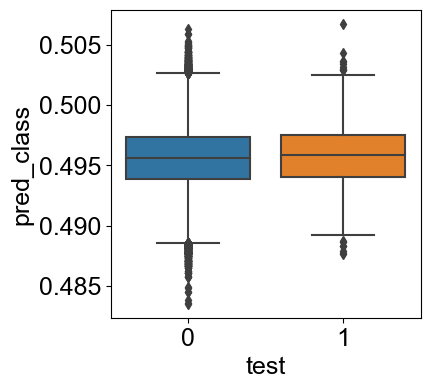

In [73]:
fig, ax=plt.subplots(figsize=(4,4))
sns.boxplot(x="Y", y="pred_diffAcc", data=pt)
ax.set(xlabel="test", ylabel="pred_class")
out = PRED.strip("tsv") + ".pdf"
plt.savefig(out, bbox_inches="tight")
out

In [68]:
DATA_PATH

'/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/hob/class.all.1task_windows/'

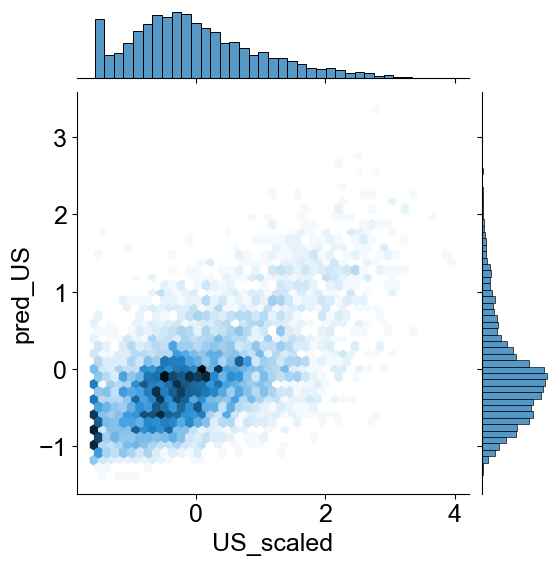

In [13]:
sns.jointplot(x="US_scaled", y="pred_US", data=pt, kind="hex")

In [14]:
dif_acc = pd.read_csv(DIFF_ACC, sep='\t', header=None, 
                      names=["#chr_da", "start_da", "end_da", "id_da", 
                      "#chr_peak","start_peak", "end_peak", "type" ]
                     )
# get true differentially accessible peaks 
test_dif_acc = set(dif_acc.loc[dif_acc["#chr_peak"] == TEST_CHR, "type"])

# annotate ids that are differentially accessible according to DESEQ2
pt.loc[pt["type"].isin(test_dif_acc), "diff_acc"] = True

In [15]:
len(test_dif_acc)

57

## compute score differences

In [21]:
pt["ctrl-us"]= pt["ctrl_scaled"] - pt["US_scaled"]
pt["pred_ctrl-pred_us"]= pt["pred_ctrl"] - pt["pred_US"]

## correlation between predictions

In [22]:
pt.corr()

,US,ctrl,US_scaled,ctrl_scaled,pred_US,pred_ctrl,diff_acc,ctrl-us,pred_ctrl-pred_us
US,1.000000,0.918129,1.000000,0.918129,0.604104,0.598814,-0.020169,-0.202325,0.102666
ctrl,0.918129,1.000000,0.918129,1.000000,0.613885,0.611052,-0.023761,0.202325,0.146513
US_scaled,1.000000,0.918129,1.000000,0.918129,0.604104,0.598814,-0.020169,-0.202325,0.102666
ctrl_scaled,0.918129,1.000000,0.918129,1.000000,0.613885,0.611052,-0.023761,0.202325,0.146513
pred_US,0.604104,0.613885,0.604104,0.613885,1.000000,0.998332,0.003519,0.024170,0.287541
pred_ctrl,0.598814,0.611052,0.598814,0.611052,0.998332,1.000000,0.003763,0.030243,0.342359
diff_acc,-0.020169,-0.023761,-0.020169,-0.023761,0.003519,0.003763,1.000000,-0.008875,0.005171
ctrl-us,-0.202325,0.202325,-0.202325,0.202325,0.024170,0.030243,-0.008875,1.000000,0.108358
pred_ctrl-pred_us,0.102666,0.146513,0.102666,0.146513,0.287541,0.342359,0.005171,0.108358,1.000000


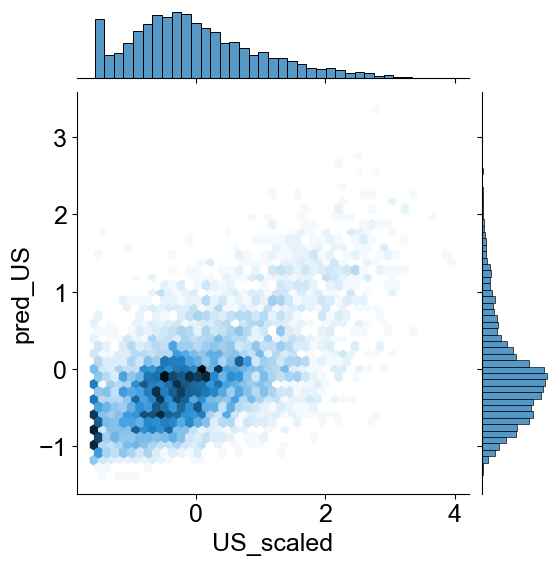

In [18]:
sns.jointplot(x="US_scaled", y="pred_US", data=pt, kind="hex")

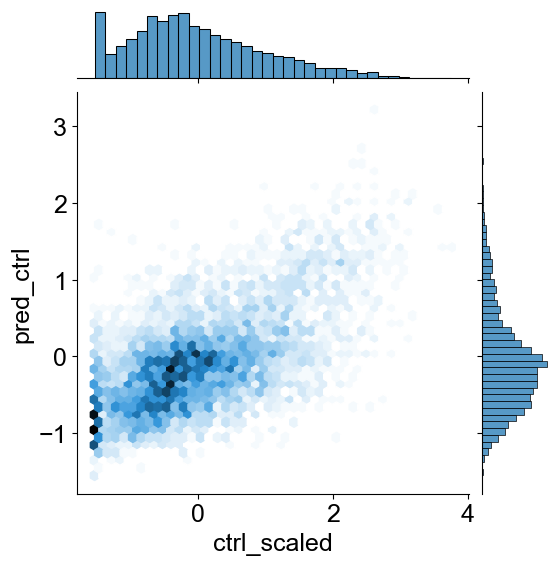

In [19]:
sns.jointplot(x="ctrl_scaled", y="pred_ctrl", data=pt, kind="hex")

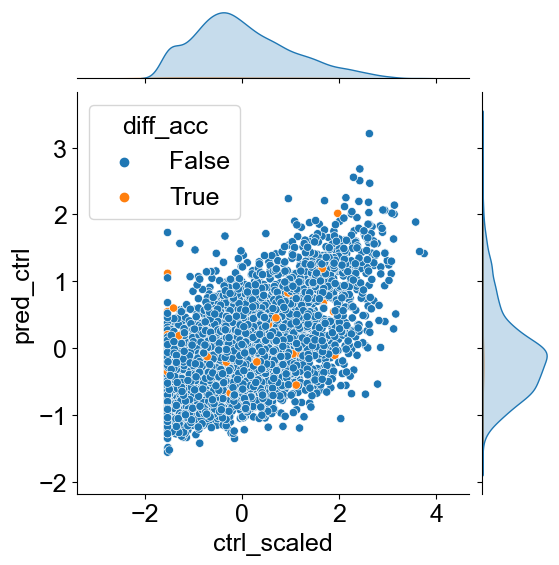

In [20]:
sns.jointplot(x="ctrl_scaled", y="pred_ctrl", data=pt, hue="diff_acc")

<AxesSubplot:xlabel='ctrl-us', ylabel='pred_ctrl-pred_us'>

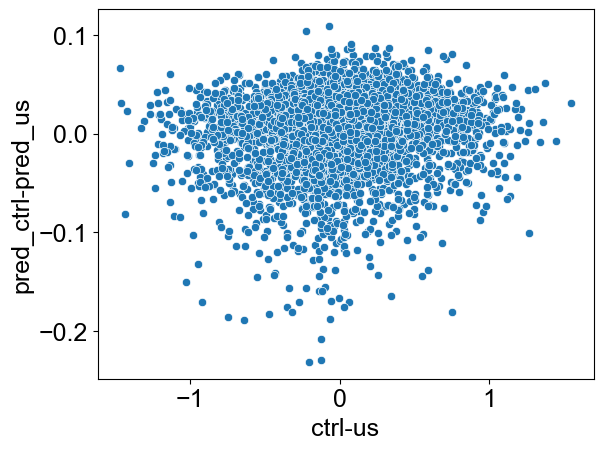

In [23]:
x = "ctrl-us"
y = "pred_ctrl-pred_us"
sns.scatterplot(x=x,y=y, data=pt)

## evaluate diff accessible

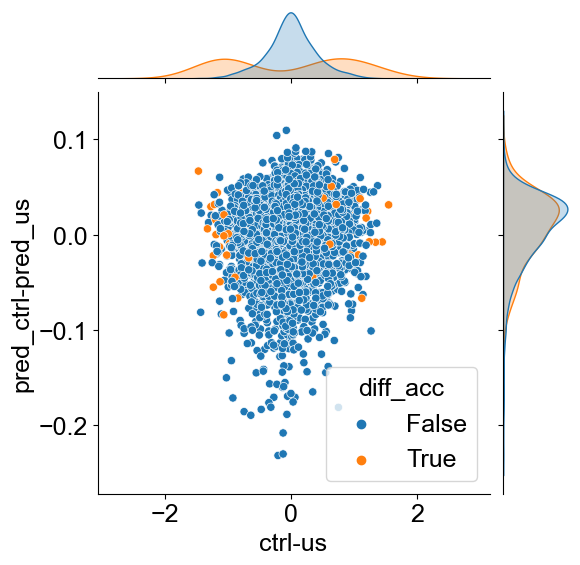

In [28]:
sns.jointplot(x=x,y=y, data=pt, hue="diff_acc", marginal_kws={"common_norm":False})

In [29]:
pt.loc[pt["diff_acc"]==True].corr()

,US,ctrl,US_scaled,ctrl_scaled,pred_US,pred_ctrl,diff_acc,ctrl-us,pred_ctrl-pred_us
US,1.000000,0.537837,1.000000,0.537837,0.419272,0.414859,NaN,-0.271611,0.058642
ctrl,0.537837,1.000000,0.537837,1.000000,0.449556,0.453347,NaN,0.665274,0.201246
US_scaled,1.000000,0.537837,1.000000,0.537837,0.419272,0.414859,NaN,-0.271611,0.058642
ctrl_scaled,0.537837,1.000000,0.537837,1.000000,0.449556,0.453347,NaN,0.665274,0.201246
pred_US,0.419272,0.449556,0.419272,0.449556,1.000000,0.998253,NaN,0.141898,0.282383
pred_ctrl,0.414859,0.453347,0.414859,0.453347,0.998253,1.000000,NaN,0.150134,0.338572
diff_acc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ctrl-us,-0.271611,0.665274,-0.271611,0.665274,0.141898,0.150134,NaN,1.000000,0.177805
pred_ctrl-pred_us,0.058642,0.201246,0.058642,0.201246,0.282383,0.338572,NaN,0.177805,1.000000


In [26]:
pt.loc[pt["diff_acc"]==True].corr(method="spearman")

,US,ctrl,US_scaled,ctrl_scaled,pred_US,pred_ctrl,diff_acc,ctrl-us,pred_ctrl-pred_us
US,1.000000,0.476403,1.000000,0.476403,0.359745,0.346310,NaN,-0.377211,0.103786
ctrl,0.476403,1.000000,0.476403,1.000000,0.405516,0.403459,NaN,0.607467,0.240273
US_scaled,1.000000,0.476403,1.000000,0.476403,0.359745,0.346310,NaN,-0.377211,0.103786
ctrl_scaled,0.476403,1.000000,0.476403,1.000000,0.405516,0.403459,NaN,0.607467,0.240273
pred_US,0.359745,0.405516,0.359745,0.405516,1.000000,0.997537,NaN,0.067541,0.566697
pred_ctrl,0.346310,0.403459,0.346310,0.403459,0.997537,1.000000,NaN,0.070490,0.598068
diff_acc,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ctrl-us,-0.377211,0.607467,-0.377211,0.607467,0.067541,0.070490,NaN,1.000000,0.128275
pred_ctrl-pred_us,0.103786,0.240273,0.103786,0.240273,0.566697,0.598068,NaN,0.128275,1.000000


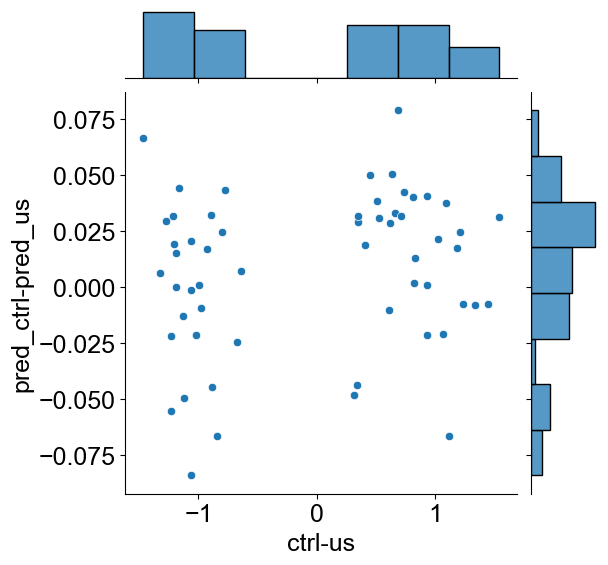

In [27]:
sns.jointplot(x=x,y=y, data=pt.loc[pt["diff_acc"]==True], marginal_kws={"common_norm":False})